In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from sklearn.preprocessing import MinMaxScaler # Importing the Keras libraries and packages from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [4]:
import pandas as pd

# Import data
df = pd.read_csv('training_project2.csv')

# Drop date variable
df = df.drop(columns=['open', 'high', 'low', 'close', 'volume', 'dividend', 'split'])

# Split data by IDs and write to different files
dfs = dict(tuple(df.groupby('id')))
list_df = [dfs[x] for x in dfs]
for index, df in enumerate(list_df):
    df.to_csv("data_by_id/" + str(index) + ".csv", index=False)

In [2]:
df = pd.read_csv("stock_by_id/0.csv", index_col="time",parse_dates=True)
df_append = pd.read_csv("stock_by_id_test/0.csv", index_col="time",parse_dates=True)

train_size = df.shape[0]
test_size = df_append.shape[0]

df = df.append(df_append)
df = df.drop(['id', 'adjusted_volume'], axis=1)
df['moving_average'] = df['adjusted_close'].rolling(5).mean()
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(df)

done reading


In [3]:
#acoustic data processing
import os
import gc
import numpy as np
from numpy.fft import *
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pywt 
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter, deconvolve
import warnings
warnings.filterwarnings('ignore')
print("done importing ")

done importing 


In [4]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)
def denoise_signal(x, wavelet='db3', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec(x, wavelet, mode="per")
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest(coeff[-level])

    # Calculate the univeral threshold
    uthresh = sigma * np.sqrt(2*np.log(len(x)))
    coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec(coeff, wavelet, mode='per')

(150000, 2)


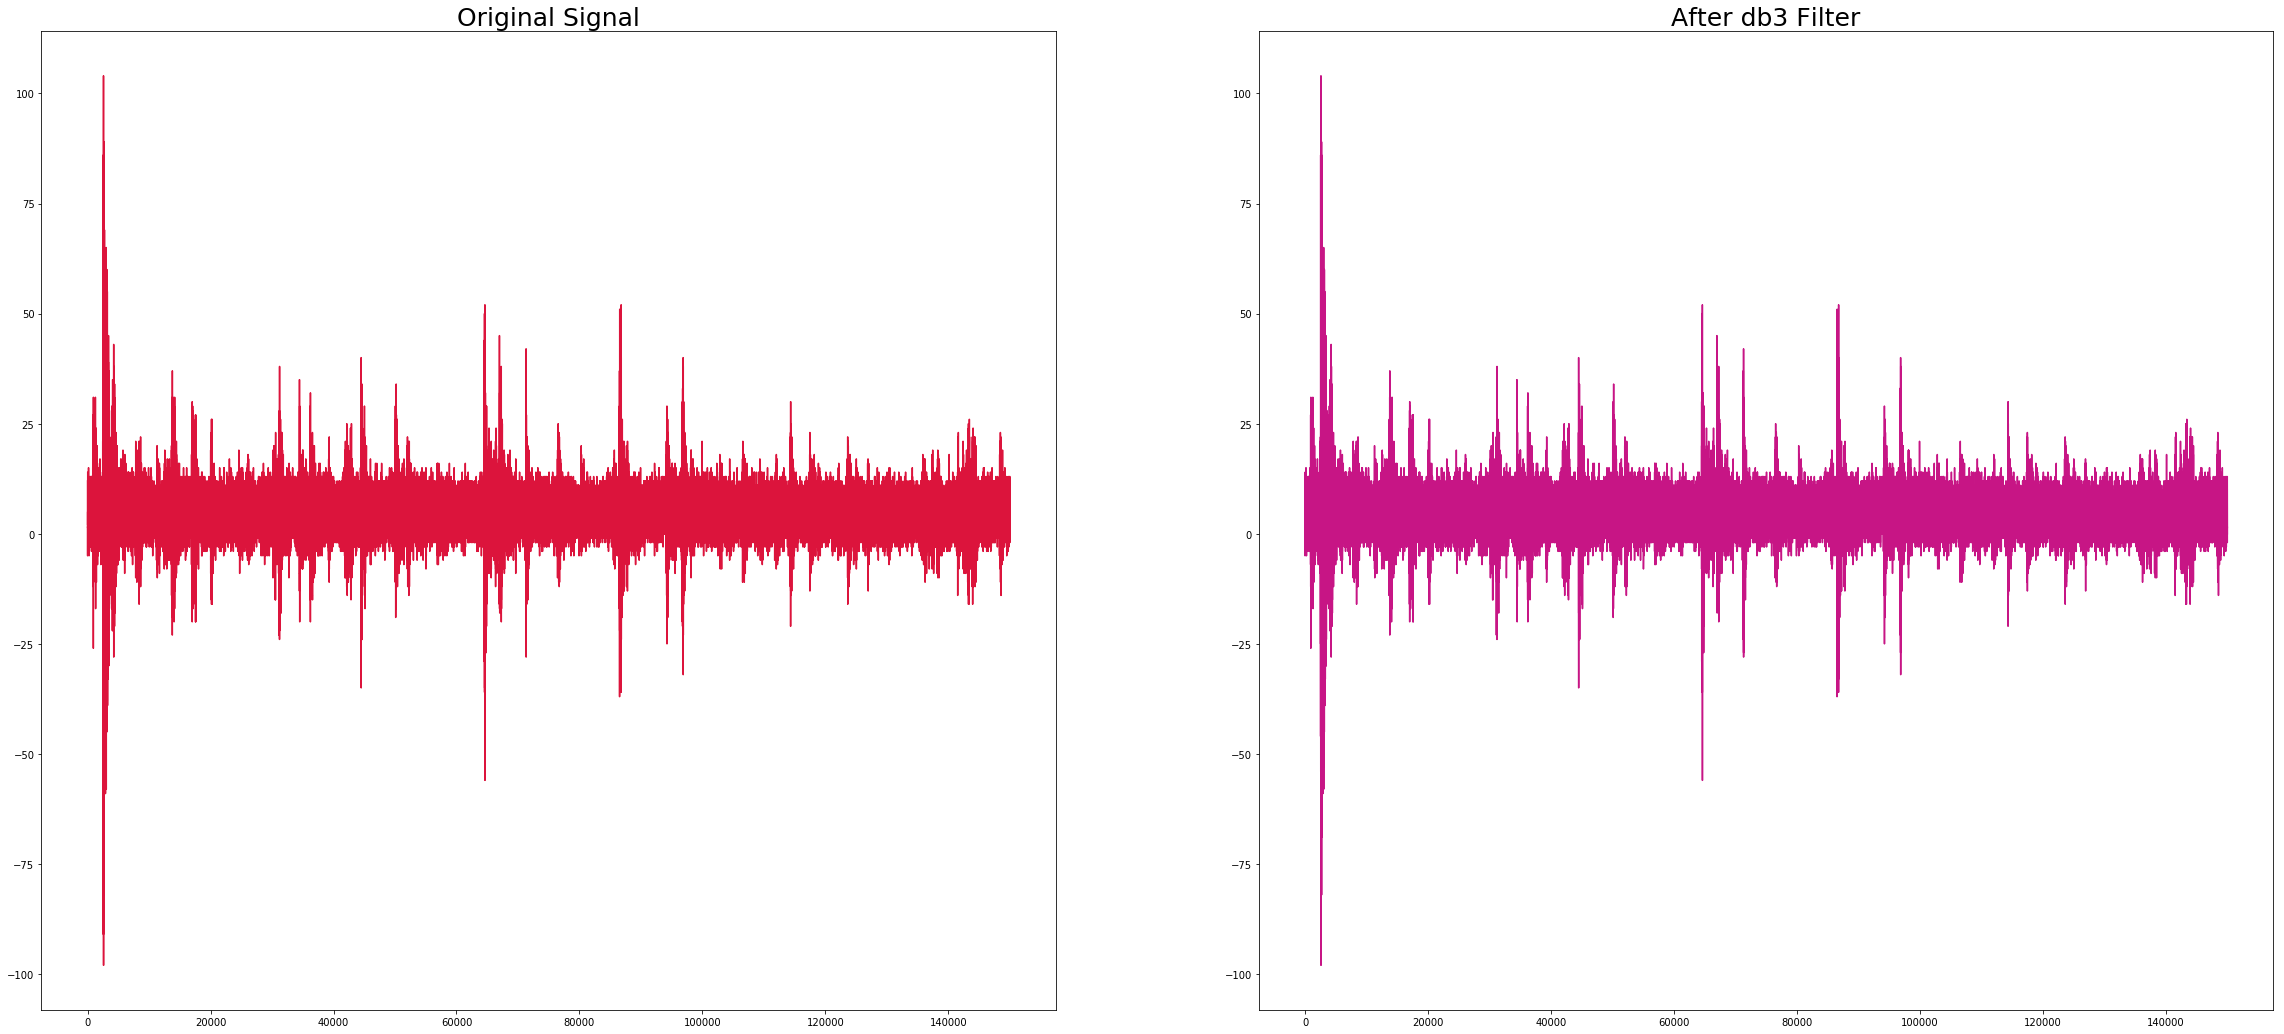

In [5]:
for test in train:
    print(test.shape)
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(40, 18))
    ax[0].plot(test, 'crimson') 
    ax[0].set_title('Original Signal', fontsize=25)
    ax[1].plot(denoise_signal(test), 'mediumvioletred') 
    ax[1].set_title('After db3 Filter', fontsize=25)
    plt.show()
    break

In [6]:
from scipy.stats import skew
import librosa, librosa.display
from scipy.stats import kurtosis

def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.mad())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
#     strain.append(  X[-150000 // 100:].max()  )
#     strain.append(  X[-150000 // 100:].min()  )
#     strain.append(  X[-150000 // 100:].mean()  )
#     strain.append(  X[-150000 // 100:].std()  )
#     strain.append(  np.quantile(X[-150000 // 100:],0.95) )
    processed = denoise_signal(X)
    strain.append(processed.mean())
    strain.append(processed.std())
    strain.append(processed.max())
#     strain.append(skew(processed))
#     strain.append(np.quantile(processed,0.05))
#     strain.append(np.quantile(processed,0.95))
#     strain.append(np.quantile(processed,0.99))
#     strain.append()
#     print(X.shape)
    nrow = np.array(X)
#     nrow = np.array(processed)
    mfcc = librosa.feature.mfcc(nrow.astype('float32'))
#     mfcc_delta = librosa.feature.delta(mfcc)
    a=(mfcc.mean(axis=1))
    av=(mfcc.var(axis=1))
    k=(kurtosis(nrow))
    npA = np.array(a)
    npAV = np.array(av)
#     print(npAV.shape)
    npBV = npAV[[0,1,2,3,7,12,13]]
    npB = npA[[16,9,11,12]]
    
#     print(np.abs(X).std())
#     print(npB)
#     print(npBV)
    for ele in npAV:
        strain.append(ele)
    for ele in npA:
        strain.append(ele)
 

    strain.append(k)
    
    return pd.Series(strain)

In [7]:

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
#     print(df['acoustic_data'].shape)
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
print("done")

done


In [8]:
X_train.describe()

,0,1,2,3,4,5,6,7,8,9,...,48,49,50,51,52,53,54,55,56,57
count,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,...,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000,4194.000000
mean,4.519388,6.548133,-149.203147,163.536481,3.482951,68.306255,0.125866,-11.225372,-2.184824,11.231772,...,4.594115,-0.237957,-0.269843,4.413044,8.229991,4.861176,0.581347,0.592745,3.702231,68.303938
std,0.256018,8.504924,265.118413,272.961327,1.621327,70.538947,0.477953,14.108446,2.346837,2.358346,...,0.440287,1.060477,1.222597,0.511675,1.422705,0.653721,0.822114,0.723975,0.365910,70.536596
min,3.596313,2.802720,-5515.000000,23.000000,2.199321,0.648602,-4.091826,-336.000000,-39.000000,9.000000,...,2.860686,-5.144846,-5.817983,2.812925,4.408713,2.934137,-3.085215,-1.825072,2.278911,0.648540
25%,4.349485,4.478118,-154.000000,92.000000,2.820130,28.081279,-0.040780,-14.000000,-3.000000,10.000000,...,4.298990,-1.022536,-1.190287,4.071544,7.176281,4.397275,0.003652,0.053052,3.458276,28.080303
50%,4.521987,5.618809,-111.000000,123.000000,3.324642,45.840610,0.085637,-10.000000,-2.000000,11.000000,...,4.602250,-0.371448,-0.472115,4.412424,8.490547,4.886693,0.522778,0.503838,3.701892,45.839042
75%,4.693332,6.880962,-79.000000,170.000000,3.805597,78.689861,0.253946,-6.000000,-1.000000,12.000000,...,4.898144,0.569851,0.638724,4.745820,9.266413,5.310724,1.156550,1.105192,3.946380,78.687198
max,5.391993,153.703569,-15.000000,5444.000000,31.724966,631.158927,4.219429,-2.000000,0.000000,50.000000,...,6.333773,2.748471,3.051075,7.645220,14.111503,7.580025,3.011225,2.808952,5.274057,631.137848


In [13]:
m = CatBoostRegressor(iterations=4000, loss_function='MAE', boosting_type='Ordered')
m.fit(X_train, y_train, metric_period=100, verbose = 1000)
m.save_model("boosting5000", format="python")
m.best_score_
print("done")

0:	learn: 5.6700990	total: 67.7ms	remaining: 4m 30s
1000:	learn: 1.9078314	total: 54.8s	remaining: 2m 44s
2000:	learn: 1.7896743	total: 1m 48s	remaining: 1m 48s
3000:	learn: 1.7012725	total: 2m 42s	remaining: 54s
3999:	learn: 1.6219358	total: 3m 35s	remaining: 0us
done


In [14]:
submission = pd.read_csv('sample_submission.csv', index_col='seg_id')
X_test = pd.DataFrame()

for seg_id in submission.index:
    seg = pd.read_csv('test/' + seg_id + '.csv')
    ch = gen_features(seg['acoustic_data'])
    X_test = X_test.append(ch, ignore_index=True)
print("done")

NameError: name 'done' is not defined

In [15]:
submission['time_to_failure'] = m.predict(X_test).clip(0, 16)
submission.to_csv('submission4000db3.csv')
print("done")

done
